In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import tqdm

#from utils import *
#from methods import *

In [3]:
from models import Similitude, Similitude2
model = Similitude2(scale=None,ncells=7) #146.2

In [4]:
if True:
    # Overwrite Initial Phase Placements
    start_phases = torch.normal(torch.zeros((model.ncells,2))+0.2,0.01)
    #start_phases = torch.cat([torch.normal(torch.zeros((model.ncells//2,2)),0.01),torch.normal(torch.zeros((model.ncells//2,2))+0.2,0.01)])
    
    model.set_phases(start_phases)

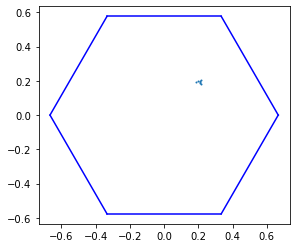

In [5]:
fig,ax=model.unit_cell.plot()
ax.scatter(*model.phases.detach().T,s=1)

In [6]:
# Train model
nsamples_space = 2**10
loss_history = []
phases_history = [model.phases.clone().detach().numpy()]
scale_history = []
for epoch in tqdm.trange(6000):
    rs = model.unit_cell.sample(nsamples_space)
    rs = torch.tensor(rs,dtype=torch.float32)
    loss = model.train_step(rs)
    loss_history.append(loss)
    phases_history.append(model.phases.clone().detach().numpy())
    scale_history.append(model.scale.clone().detach().numpy())

100%|██████████████████████████████████████| 6000/6000 [00:08<00:00, 712.78it/s]


In [7]:
# test time to sample and time to train to see where comp. bottleneck is.
%timeit -n 20 model.unit_cell.sample(nsamples_space)
%timeit -n 20 model.train_step(rs)

345 µs ± 16.7 µs per loop (mean ± std. dev. of 7 runs, 20 loops each)
990 µs ± 8.48 µs per loop (mean ± std. dev. of 7 runs, 20 loops each)


1.1121291387805599e-11

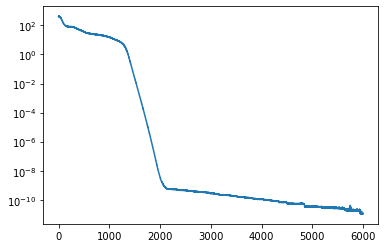

In [8]:
plt.semilogy(loss_history)
loss_history[-1]

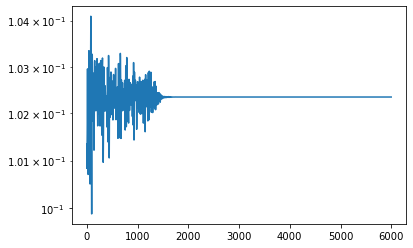

In [9]:
plt.semilogy(scale_history)

In [10]:
J = model.jacobian(rs)
metric_tensor = model.metric_tensor(J)

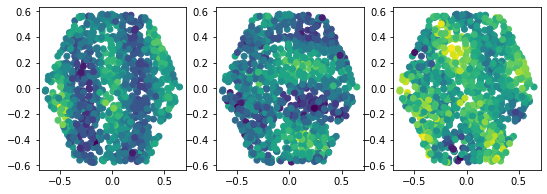

In [11]:
fig,axs = plt.subplots(ncols=3,figsize=(9,3))
axs[0].scatter(*rs.T,c=metric_tensor[...,0,0].detach())
axs[1].scatter(*rs.T,c=metric_tensor[...,1,1].detach())
axs[2].scatter(*rs.T,c=metric_tensor[...,1,0].detach())
#plt.colorbar()

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

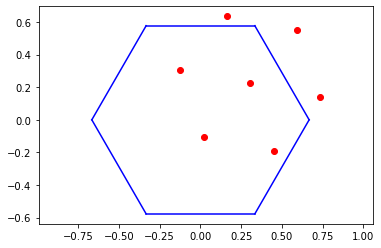

In [12]:
N = len(phases_history)
fig, ax = plt.subplots()
#[ax.scatter(*phases_history[i].T, c='grey') for i in range(N)]
ax.scatter(*phases_history[-1].T, c='red')
ax.axis('equal')
model.unit_cell.plot(fig,ax)
#model.unit_cell.plot(fig,ax,center=np.mean(phases_history[-1],axis=0))

In [13]:
torch.save(model,f'./saved-models/{type(model).__name__}-{model.ncells}-dirac')

In [ ]:
# dropout?
# figure out the geodesic between phases
# - finds hexagons